# Day 1: GARCH(1,1) Model

## Learning Objectives
- Understand volatility clustering and GARCH motivation
- Implement GARCH(1,1) model
- Interpret GARCH parameters
- Forecast volatility

## Key Formula
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy import stats
from pathlib import Path

# Configuration
DATA_DIR = Path('../datasets/raw_data')
TRADING_DAYS = 252

# Load data
df = pd.read_csv(DATA_DIR / 'combined_adjusted_close.csv', index_col='Date', parse_dates=True)
prices = df.ffill().dropna()
returns = prices.pct_change().dropna() * 100  # Percentage returns

print("="*60)
print("GARCH(1,1) MODEL - DAY 1")
print("="*60)
print(f"Data: {len(returns)} days, {len(returns.columns)} assets")

GARCH(1,1) MODEL - DAY 1
Data: 1834 days, 63 assets


## 1. Volatility Clustering Evidence

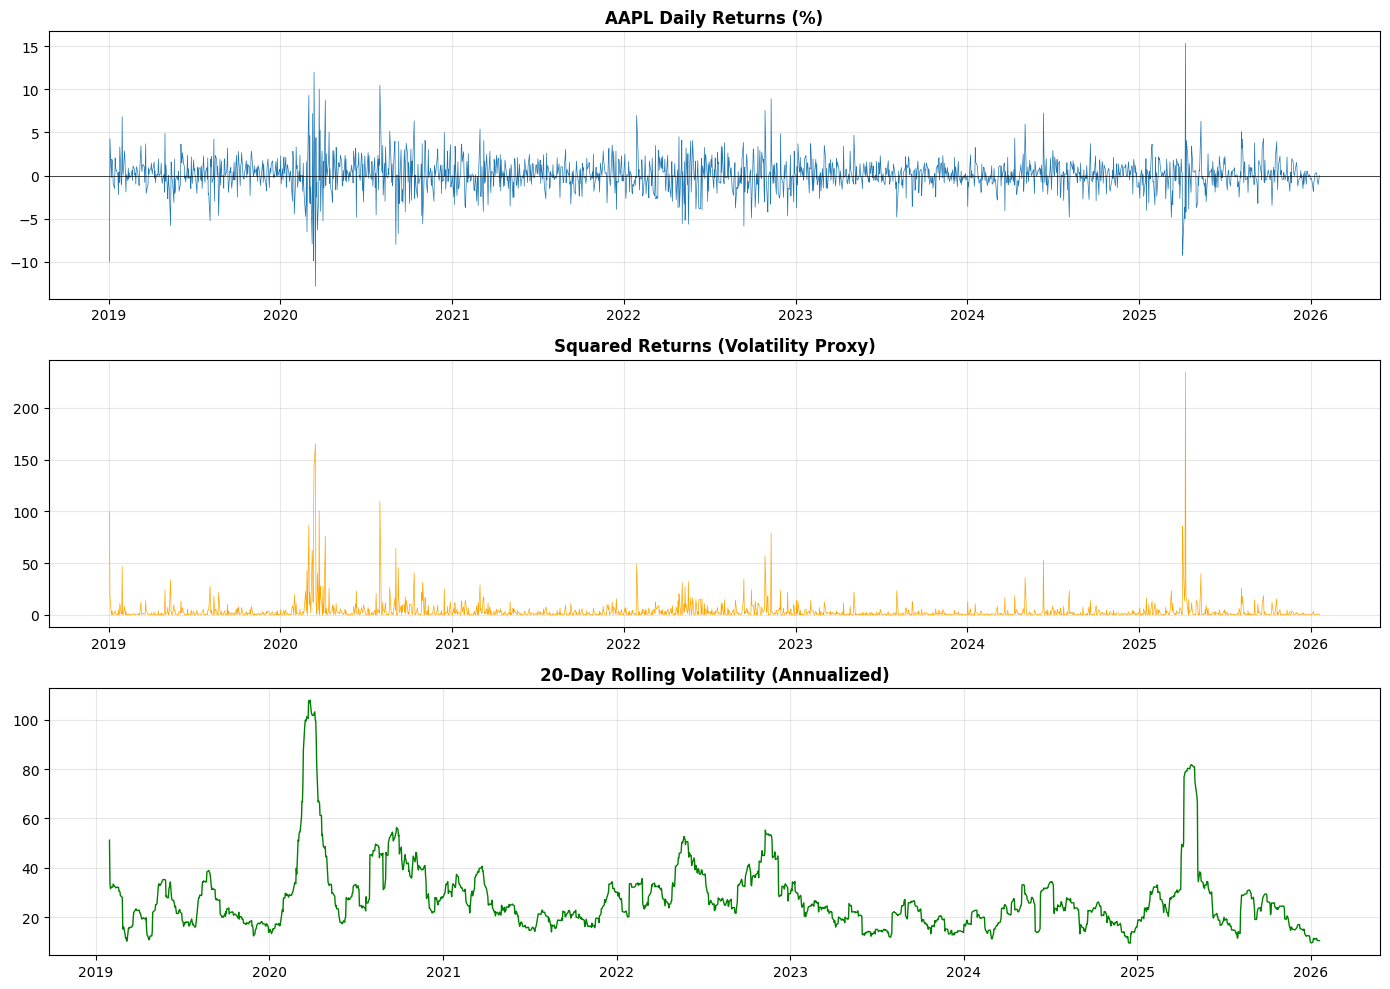


💡 Observation: Large returns cluster together - this is volatility clustering!


In [2]:
# Select a stock for analysis
stock = 'AAPL'
stock_returns = returns[stock].dropna()

# Plot returns and squared returns
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Returns
ax1 = axes[0]
ax1.plot(stock_returns, linewidth=0.5)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.set_title(f'{stock} Daily Returns (%)', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Squared returns (volatility proxy)
ax2 = axes[1]
ax2.plot(stock_returns**2, linewidth=0.5, color='orange')
ax2.set_title('Squared Returns (Volatility Proxy)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Rolling volatility
ax3 = axes[2]
rolling_vol = stock_returns.rolling(20).std() * np.sqrt(TRADING_DAYS)
ax3.plot(rolling_vol, linewidth=1, color='green')
ax3.set_title('20-Day Rolling Volatility (Annualized)', fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Observation: Large returns cluster together - this is volatility clustering!")


ARCH LM TEST
LM Statistic: 262.6992
P-value: 0.000000

Conclusion: ARCH effects present


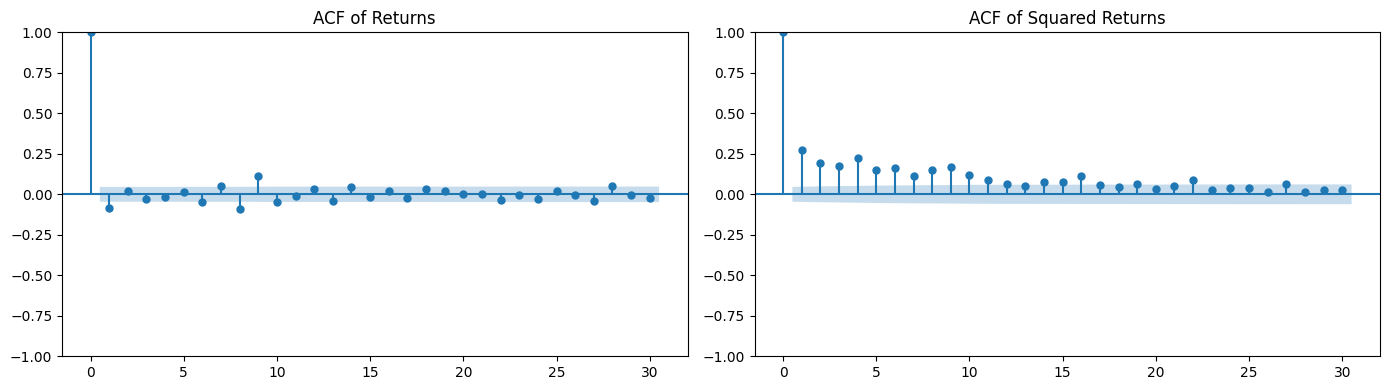


💡 Squared returns show significant autocorrelation - confirms volatility clustering


In [3]:
# Test for ARCH effects
from statsmodels.stats.diagnostic import het_arch

# ARCH LM Test
arch_test = het_arch(stock_returns)

print("\n" + "="*60)
print("ARCH LM TEST")
print("="*60)
print(f"LM Statistic: {arch_test[0]:.4f}")
print(f"P-value: {arch_test[1]:.6f}")
print(f"\nConclusion: {'ARCH effects present' if arch_test[1] < 0.05 else 'No ARCH effects'}")

# ACF of squared returns
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(stock_returns, ax=axes[0], lags=30, title='ACF of Returns')
plot_acf(stock_returns**2, ax=axes[1], lags=30, title='ACF of Squared Returns')

plt.tight_layout()
plt.show()

print("\n💡 Squared returns show significant autocorrelation - confirms volatility clustering")

## 2. Fit GARCH(1,1) Model

In [4]:
# Fit GARCH(1,1)
model = arch_model(stock_returns, vol='GARCH', p=1, q=1, mean='Constant')
result = model.fit(disp='off')

print("\n" + "="*60)
print("GARCH(1,1) MODEL RESULTS")
print("="*60)
print(result.summary())


GARCH(1,1) MODEL RESULTS
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3581.87
Distribution:                  Normal   AIC:                           7171.74
Method:            Maximum Likelihood   BIC:                           7193.80
                                        No. Observations:                 1834
Date:                Wed, Jan 21 2026   Df Residuals:                     1833
Time:                        00:45:58   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1752  3.999e-02      

In [5]:
# Extract and interpret parameters
omega = result.params['omega']
alpha = result.params['alpha[1]']
beta = result.params['beta[1]']

print("\n" + "="*60)
print("PARAMETER INTERPRETATION")
print("="*60)

print(f"\nω (omega): {omega:.6f}")
print(f"α (alpha): {alpha:.4f} - Impact of recent shock")
print(f"β (beta):  {beta:.4f} - Persistence of past variance")

# Derived quantities
persistence = alpha + beta
unconditional_var = omega / (1 - alpha - beta)
unconditional_vol = np.sqrt(unconditional_var)

# Half-life
if persistence < 1:
    half_life = np.log(0.5) / np.log(persistence)
else:
    half_life = float('inf')

print(f"\nDerived Quantities:")
print(f"   Persistence (α + β): {persistence:.4f}")
print(f"   Unconditional Variance: {unconditional_var:.4f}")
print(f"   Unconditional Vol (daily %): {unconditional_vol:.2f}%")
print(f"   Unconditional Vol (annual %): {unconditional_vol * np.sqrt(TRADING_DAYS):.2f}%")
print(f"   Half-life (days): {half_life:.1f}")

print(f"\n💡 Interpretation:")
print(f"   - High β ({beta:.2f}) = slow decay of volatility shocks")
print(f"   - Persistence close to 1 = long memory in volatility")
print(f"   - Half-life = {half_life:.0f} days for shock to decay 50%")


PARAMETER INTERPRETATION

ω (omega): 0.146993
α (alpha): 0.1052 - Impact of recent shock
β (beta):  0.8515 - Persistence of past variance

Derived Quantities:
   Persistence (α + β): 0.9568
   Unconditional Variance: 3.3988
   Unconditional Vol (daily %): 1.84%
   Unconditional Vol (annual %): 29.27%
   Half-life (days): 15.7

💡 Interpretation:
   - High β (0.85) = slow decay of volatility shocks
   - Persistence close to 1 = long memory in volatility
   - Half-life = 16 days for shock to decay 50%


## 3. Conditional Volatility

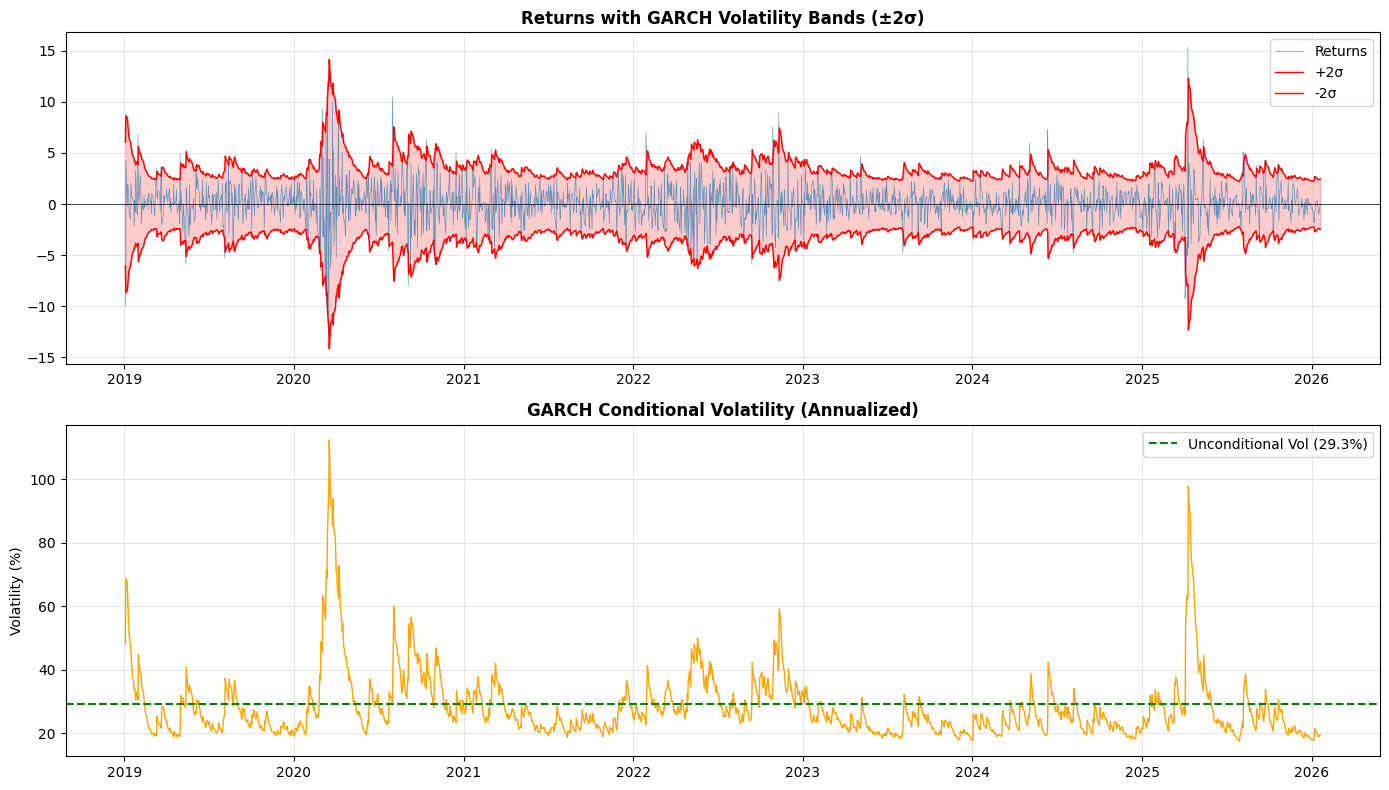

In [6]:
# Get conditional volatility
cond_vol = result.conditional_volatility

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Returns with volatility bands
ax1 = axes[0]
ax1.plot(stock_returns.index, stock_returns.values, linewidth=0.5, alpha=0.7, label='Returns')
ax1.plot(cond_vol.index, 2*cond_vol.values, 'r-', linewidth=1, label='+2σ')
ax1.plot(cond_vol.index, -2*cond_vol.values, 'r-', linewidth=1, label='-2σ')
ax1.fill_between(cond_vol.index, -2*cond_vol.values, 2*cond_vol.values, alpha=0.2, color='red')
ax1.axhline(0, color='black', linewidth=0.5)
ax1.set_title('Returns with GARCH Volatility Bands (±2σ)', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Conditional volatility
ax2 = axes[1]
ax2.plot(cond_vol.index, cond_vol.values * np.sqrt(TRADING_DAYS), linewidth=1, color='orange')
ax2.axhline(unconditional_vol * np.sqrt(TRADING_DAYS), color='green', linestyle='--', 
           label=f'Unconditional Vol ({unconditional_vol * np.sqrt(TRADING_DAYS):.1f}%)')
ax2.set_title('GARCH Conditional Volatility (Annualized)', fontweight='bold')
ax2.set_ylabel('Volatility (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Volatility Forecasting


VOLATILITY FORECAST (20 DAYS)
Day    Variance     Vol (daily)  Vol (ann.)  
---------------------------------------------
h=1    1.4422       1.20        % 19.06       %
h=2    1.5268       1.24        % 19.62       %
h=3    1.6078       1.27        % 20.13       %
h=4    1.6852       1.30        % 20.61       %
h=5    1.7593       1.33        % 21.06       %
h=6    1.8302       1.35        % 21.48       %
h=7    1.8981       1.38        % 21.87       %
h=8    1.9630       1.40        % 22.24       %
h=9    2.0251       1.42        % 22.59       %
h=10   2.0845       1.44        % 22.92       %
h=11   2.1413       1.46        % 23.23       %
h=12   2.1957       1.48        % 23.52       %
h=13   2.2477       1.50        % 23.80       %
h=14   2.2975       1.52        % 24.06       %
h=15   2.3451       1.53        % 24.31       %
h=16   2.3907       1.55        % 24.55       %
h=17   2.4343       1.56        % 24.77       %
h=18   2.4760       1.57        % 24.98       %
h=19   2.5159

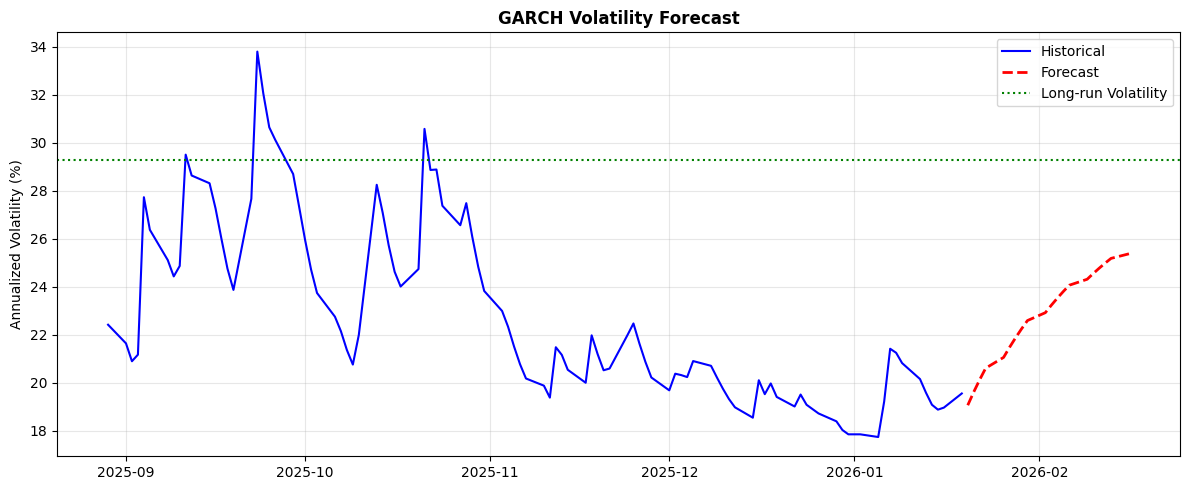


💡 Volatility forecast converges to unconditional level over time


In [7]:
# Forecast volatility
forecast_horizon = 20
forecast = result.forecast(horizon=forecast_horizon)

# Extract forecasted variance
forecast_variance = forecast.variance.iloc[-1]
forecast_vol = np.sqrt(forecast_variance)

print("\n" + "="*60)
print(f"VOLATILITY FORECAST ({forecast_horizon} DAYS)")
print("="*60)
print(f"{'Day':<6} {'Variance':<12} {'Vol (daily)':<12} {'Vol (ann.)':<12}")
print("-"*45)

for i, (var, vol) in enumerate(zip(forecast_variance, forecast_vol), 1):
    print(f"h={i:<4} {var:<12.4f} {vol:<12.2f}% {vol*np.sqrt(TRADING_DAYS):<12.2f}%")

# Plot forecast
fig, ax = plt.subplots(figsize=(12, 5))

# Historical
hist_vol_ann = cond_vol * np.sqrt(TRADING_DAYS)
ax.plot(hist_vol_ann.iloc[-100:], label='Historical', color='blue')

# Forecast
forecast_dates = pd.date_range(start=cond_vol.index[-1], periods=forecast_horizon+1, freq='B')[1:]
forecast_vol_ann = forecast_vol * np.sqrt(TRADING_DAYS)
ax.plot(forecast_dates, forecast_vol_ann, 'r--', linewidth=2, label='Forecast')

# Unconditional
ax.axhline(unconditional_vol * np.sqrt(TRADING_DAYS), color='green', linestyle=':', 
          label='Long-run Volatility')

ax.set_title('GARCH Volatility Forecast', fontweight='bold')
ax.set_ylabel('Annualized Volatility (%)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Volatility forecast converges to unconditional level over time")

## 5. Model Diagnostics

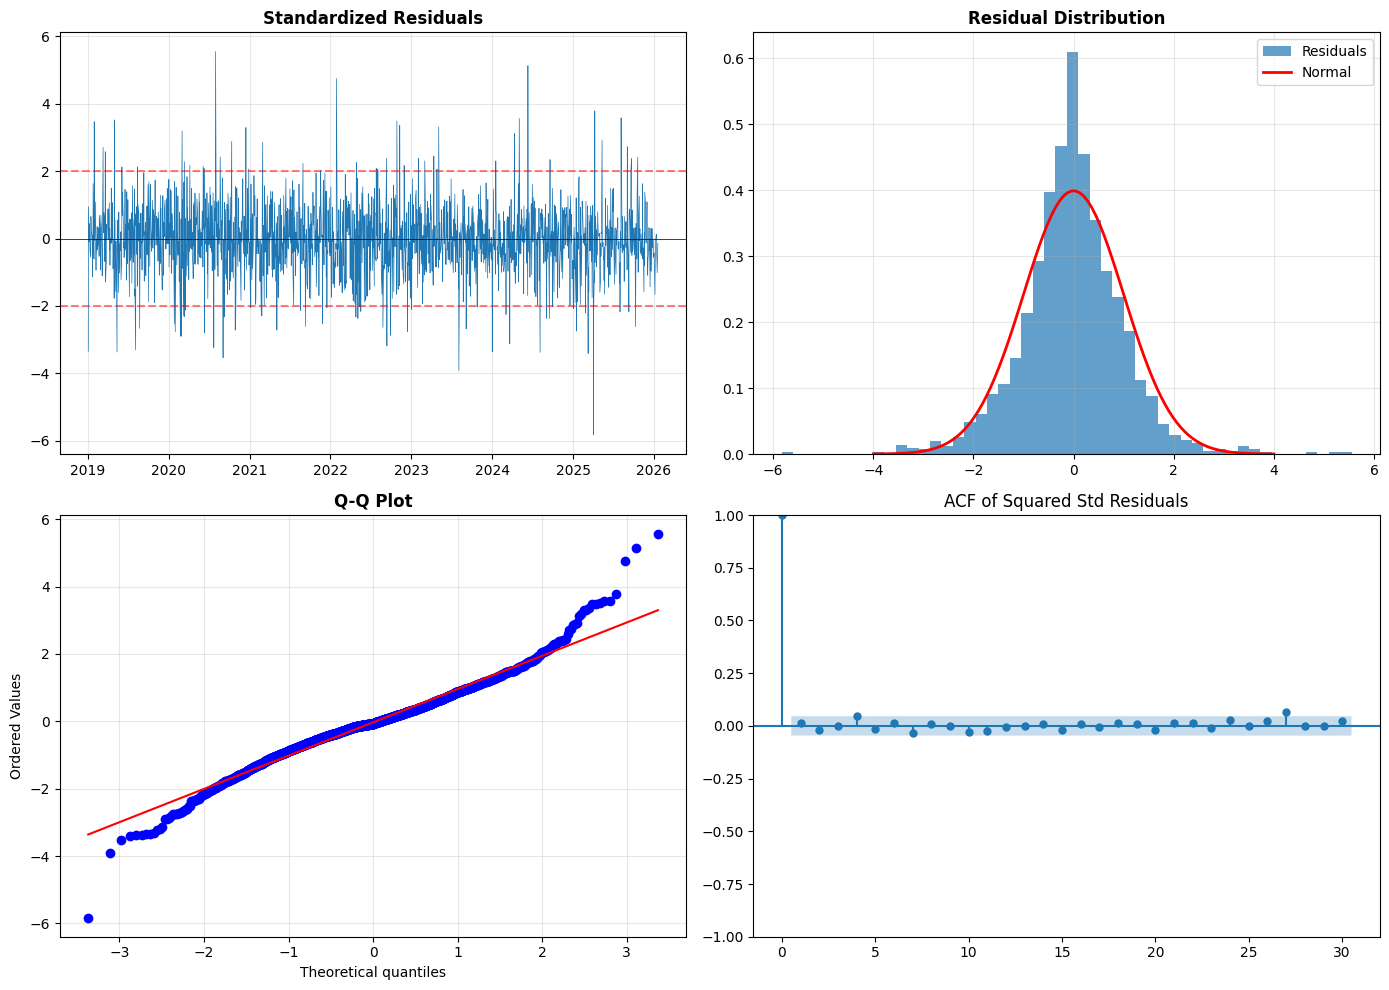


Jarque-Bera Test: Statistic=575.08, p-value=0.000000
Conclusion: Residuals are not normally distributed


In [8]:
# Standardized residuals
std_resid = result.std_resid

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Standardized residuals
ax1 = axes[0, 0]
ax1.plot(std_resid, linewidth=0.5)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.axhline(2, color='red', linestyle='--', alpha=0.5)
ax1.axhline(-2, color='red', linestyle='--', alpha=0.5)
ax1.set_title('Standardized Residuals', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Histogram
ax2 = axes[0, 1]
ax2.hist(std_resid, bins=50, density=True, alpha=0.7, label='Residuals')
x = np.linspace(-4, 4, 100)
ax2.plot(x, stats.norm.pdf(x), 'r-', linewidth=2, label='Normal')
ax2.set_title('Residual Distribution', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# QQ plot
ax3 = axes[1, 0]
stats.probplot(std_resid.dropna(), dist='norm', plot=ax3)
ax3.set_title('Q-Q Plot', fontweight='bold')
ax3.grid(True, alpha=0.3)

# ACF of squared standardized residuals
ax4 = axes[1, 1]
plot_acf(std_resid**2, ax=ax4, lags=30, title='ACF of Squared Std Residuals')

plt.tight_layout()
plt.show()

# Jarque-Bera test
jb_stat, jb_pval = stats.jarque_bera(std_resid.dropna())
print(f"\nJarque-Bera Test: Statistic={jb_stat:.2f}, p-value={jb_pval:.6f}")
print(f"Conclusion: Residuals are {'not ' if jb_pval < 0.05 else ''}normally distributed")

## 6. Compare Multiple Stocks

In [9]:
# Fit GARCH to multiple stocks
test_stocks = ['AAPL', 'MSFT', 'JPM', 'XOM', 'SPY']

print("\n" + "="*70)
print("GARCH(1,1) COMPARISON")
print("="*70)
print(f"{'Stock':<8} {'ω':<12} {'α':<10} {'β':<10} {'α+β':<10} {'Uncond Vol':<12}")
print("-"*70)

garch_results = {}
for s in test_stocks:
    if s in returns.columns:
        model = arch_model(returns[s].dropna(), vol='GARCH', p=1, q=1)
        res = model.fit(disp='off')
        garch_results[s] = res
        
        omega = res.params['omega']
        alpha = res.params['alpha[1]']
        beta = res.params['beta[1]']
        persist = alpha + beta
        uncond_vol = np.sqrt(omega / (1 - alpha - beta)) * np.sqrt(TRADING_DAYS)
        
        print(f"{s:<8} {omega:<12.6f} {alpha:<10.4f} {beta:<10.4f} {persist:<10.4f} {uncond_vol:<12.2f}%")


GARCH(1,1) COMPARISON
Stock    ω            α          β          α+β        Uncond Vol  
----------------------------------------------------------------------
AAPL     0.146993     0.1052     0.8515     0.9568     29.27       %
MSFT     0.102176     0.1009     0.8637     0.9646     26.97       %
JPM      0.141614     0.1031     0.8476     0.9507     26.91       %
XOM      0.039448     0.0685     0.9208     0.9894     30.61       %
SPY      0.044896     0.1661     0.8002     0.9663     18.32       %


## Key Takeaways

1. **GARCH captures volatility clustering** - large returns followed by large returns
2. **Parameters**: α measures shock impact, β measures persistence
3. **Persistence (α+β)** typically close to 1 for financial data
4. **Half-life** measures how long shocks take to decay
5. **Forecasts** converge to unconditional volatility

### GARCH(1,1) Formula
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

---
*Next: Day 2 - EGARCH for Leverage Effects*